In [ ]:
# Copyright (c) MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Classifier-free Guidance

This tutorial illustrates how to use MONAI for training a denoising diffusion probabilistic model (DDPM)[1] to create synthetic 2D images using the classifier-free guidance technique [2] to perform conditioning.


[1] - Ho et al. "Denoising Diffusion Probabilistic Models" https://arxiv.org/abs/2006.11239
[2] - Ho and Salimans "Classifier-Free Diffusion Guidance" https://arxiv.org/abs/2207.12598



## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## Setup imports

In [2]:
import os
import shutil
import tempfile
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from monai import transforms
from monai.apps import MedNISTDataset
from monai.config import print_config
from monai.data import CacheDataset, DataLoader
from monai.utils import first, set_determinism
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

from generative.inferers import DiffusionInferer
from generative.networks.nets import DiffusionModelUNet
from generative.networks.schedulers import DDPMScheduler

print_config()

MONAI version: 1.1.dev2239
Numpy version: 1.23.3
Pytorch version: 1.8.0+cu111
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 13b24fa92b9d98bd0dc6d5cdcb52504fd09e297b
MONAI __file__: /media/walter/Storage/Projects/GenerativeModels/venv/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
Nibabel version: 4.0.2
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 9.2.0
Tensorboard version: 2.11.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.9.0+cu111
tqdm version: 4.64.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.3
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: 0.6.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai

## Setup data directory

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmp142o2qtd


## Set deterministic training for reproducibility

In [4]:
set_determinism(42)

## Setup MedNIST Dataset and training and validation dataloaders
In this tutorial, we will train our models on the MedNIST dataset available on MONAI
(https://docs.monai.io/en/stable/apps.html#monai.apps.MedNISTDataset).
Here, we will use the "Hand" and "HeadCT", where our conditioning variable `class` will specify the modality.

In [5]:
train_data = MedNISTDataset(root_dir=root_dir, section="training", download=True, progress=False, seed=0)
train_datalist = []
for item in train_data.data:
    if item["class_name"] in ["Hand", "HeadCT"]:
        train_datalist.append({"image": item["image"], "class": 1 if item["class_name"] == "Hand" else 2})

2022-12-10 11:50:40,187 - INFO - Downloaded: /tmp/tmp142o2qtd/MedNIST.tar.gz
2022-12-10 11:50:40,255 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2022-12-10 11:50:40,256 - INFO - Writing into directory: /tmp/tmp142o2qtd.


Here we use transforms to augment the training dataset, as usual:

1. `LoadImaged` loads the hands images from files.
1. `EnsureChannelFirstd` ensures the original data to construct "channel first" shape.
1. `ScaleIntensityRanged` extracts intensity range [0, 255] and scales to [0, 1].
1. `RandAffined` efficiently performs rotate, scale, shear, translate, etc. together based on PyTorch affine transform.

### Classifier-free guidance during training

In order to use the classifier-free guidance during training time, we need to not just have the `class` variable saying the modality of the image (`1` for Hands and `2` for HeadCTs) but we also need to train the model with an "unconditional" class.
Here we specify the "unconditional" class with the value `-1` with a probability of training on unconditional being 15%. Specified in the following line using MONAI's RandLambdad:

`transforms.RandLambdad(keys=["class"], prob=0.15, func=lambda x: -1 * torch.ones_like(x))`

Finally, our conditioning variable need to have the format (batch_size, 1, cross_attention_dim) when feeding into the model. For this reason, we use Lambdad to reshape our variables in the right format.

In [6]:
train_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
        transforms.RandAffined(
            keys=["image"],
            rotate_range=[(-np.pi / 36, np.pi / 36), (-np.pi / 36, np.pi / 36)],
            translate_range=[(-1, 1), (-1, 1)],
            scale_range=[(-0.05, 0.05), (-0.05, 0.05)],
            spatial_size=[64, 64],
            padding_mode="zeros",
            prob=0.5,
        ),
        transforms.RandLambdad(keys=["class"], prob=0.15, func=lambda x: -1 * torch.ones_like(x)),
        transforms.Lambdad(
            keys=["class"], func=lambda x: torch.tensor(x, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        ),
    ]
)
train_ds = CacheDataset(data=train_datalist, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=4, persistent_workers=True)

Loading dataset: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15990/15990 [00:08<00:00, 1784.85it/s]


In [7]:
val_data = MedNISTDataset(root_dir=root_dir, section="validation", download=True, progress=False, seed=0)
val_datalist = []
for item in val_data.data:
    if item["class_name"] in ["Hand", "HeadCT"]:
        val_datalist.append({"image": item["image"], "class": 1 if item["class_name"] == "Hand" else 2})


val_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
        transforms.Lambdad(
            keys=["class"], func=lambda x: torch.tensor(x, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        ),
    ]
)
val_ds = CacheDataset(data=val_datalist, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=128, shuffle=False, num_workers=4, persistent_workers=True)

2022-12-10 11:51:08,067 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2022-12-10 11:51:08,067 - INFO - File exists: /tmp/tmp142o2qtd/MedNIST.tar.gz, skipped downloading.
2022-12-10 11:51:08,068 - INFO - Non-empty folder exists in /tmp/tmp142o2qtd/MedNIST, skipped extracting.


Loading dataset: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1977/1977 [00:01<00:00, 1545.02it/s]


### Visualisation of the training images

/tmp/ipykernel_16221/734547315.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  keys=["class"], func=lambda x: torch.tensor(x, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
/tmp/ipykernel_16221/734547315.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  keys=["class"], func=lambda x: torch.tensor(x, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
/tmp/ipykernel_16221/734547315.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  keys=["class"], func=lambda x: torch.tensor(x, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
/tmp/ipyke

batch shape: (128, 1, 64, 64)


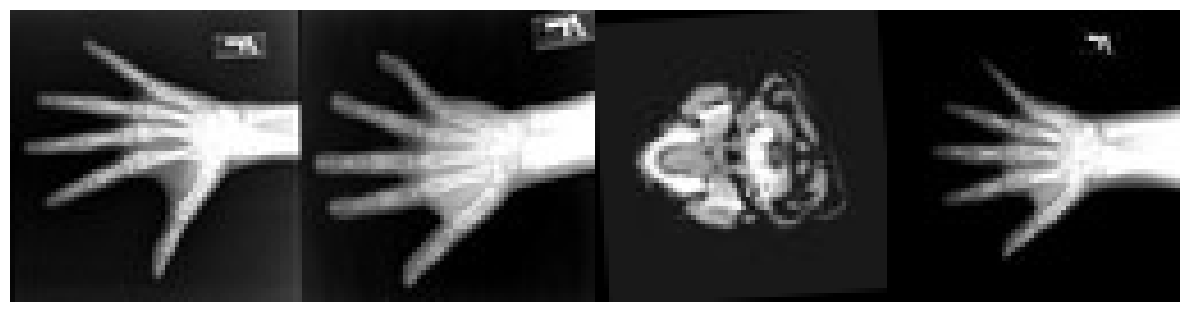

In [8]:
check_data = first(train_loader)
print(f"batch shape: {check_data['image'].shape}")
image_visualisation = torch.cat(
    [check_data["image"][0, 0], check_data["image"][1, 0], check_data["image"][2, 0], check_data["image"][3, 0]], dim=1
)
plt.figure("training images", (12, 6))
plt.imshow(image_visualisation, vmin=0, vmax=1, cmap="gray")
plt.axis("off")
plt.tight_layout()
plt.show()

### Define network, scheduler, optimizer, and inferer
At this step, we instantiate the MONAI components to create a DDPM, the UNET, the noise scheduler, and the inferer used for training and sampling. We are using
the original DDPM scheduler containing 1000 timesteps in its Markov chain, and a 2D UNET with attention mechanisms
in the 3rd level, each with 1 attention head (`num_head_channels=64`).

In order to pass conditioning variables with dimension of 1 (just specifying the modality of the image), we use:

`
with_conditioning=True,
cross_attention_dim=1,
`

In [9]:
device = torch.device("cuda")

model = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    num_channels=(64, 64, 64),
    attention_levels=(False, False, True),
    num_res_blocks=1,
    num_head_channels=(0, 0, 64),
    with_conditioning=True,
    cross_attention_dim=1,
)
model.to(device)

scheduler = DDPMScheduler(num_train_timesteps=1000)

optimizer = torch.optim.Adam(params=model.parameters(), lr=2.5e-5)

inferer = DiffusionInferer(scheduler)

### Model training
Here, we are training our model for 75 epochs (training time: ~50 minutes).

In [10]:
n_epochs = 75
val_interval = 5
epoch_loss_list = []
val_epoch_loss_list = []

scaler = GradScaler()
total_start = time.time()
for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"].to(device)
        classes = batch["class"].to(device)
        optimizer.zero_grad(set_to_none=True)

        with autocast(enabled=True):
            # Generate random noise
            noise = torch.randn_like(images).to(device)

            # Get model prediction
            noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, condition=classes)

            loss = F.mse_loss(noise_pred.float(), noise.float())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()

        progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})
    epoch_loss_list.append(epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_epoch_loss = 0
        for step, batch in enumerate(val_loader):
            images = batch["image"].to(device)
            classes = batch["class"].to(device)
            with torch.no_grad():
                with autocast(enabled=True):
                    noise = torch.randn_like(images).to(device)
                    noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, condition=classes)
                    val_loss = F.mse_loss(noise_pred.float(), noise.float())

            val_epoch_loss += val_loss.item()
            progress_bar.set_postfix({"val_loss": val_epoch_loss / (step + 1)})
        val_epoch_loss_list.append(val_epoch_loss / (step + 1))

total_time = time.time() - total_start
print(f"train completed, total time: {total_time}.")

Epoch 74: 100%|████████| 125/125 [00:27<00:00,  4.56it/s, loss=0.0125]


train completed, total time: 2074.1517136096954.


### Learning curves

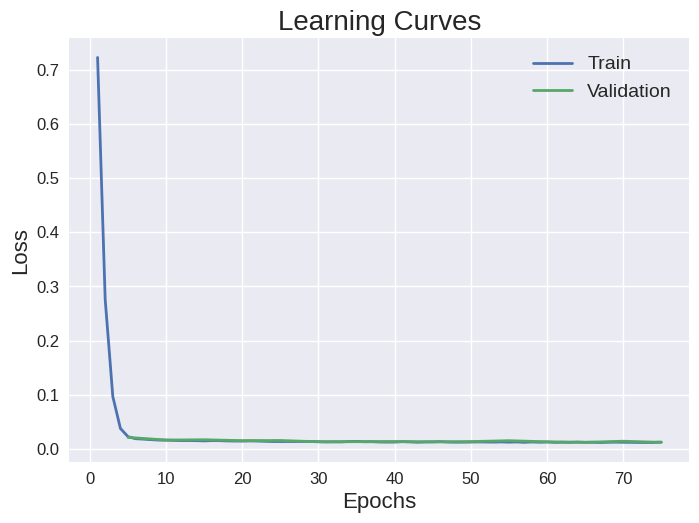

In [11]:
plt.style.use("seaborn-v0_8")
plt.title("Learning Curves", fontsize=20)
plt.plot(np.linspace(1, n_epochs, n_epochs), epoch_loss_list, color="C0", linewidth=2.0, label="Train")
plt.plot(
    np.linspace(val_interval, n_epochs, int(n_epochs / val_interval)),
    val_epoch_loss_list,
    color="C1",
    linewidth=2.0,
    label="Validation",
)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.legend(prop={"size": 14})
plt.show()

### Sampling process with classifier-free guidance
In order to sample using classifier-free guidance, for each step of the process we need to have 2 elements, one generated conditioned in the desired class (here we want to condition on Hands `=1`) and one using the unconditional class (`=-1`).
Instead using directly the predicted class in every step, we use the unconditional plus the direction vector pointing to the condition that we want (`noise_pred_text - noise_pred_uncond`). The effect of the condition is defined by the `guidance_scale` defining the influence of our direction vector.

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 71.08it/s]


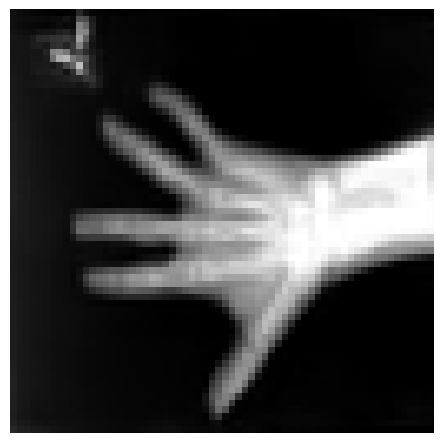

In [15]:
model.eval()
guidance_scale = 7.0
conditioning = torch.cat([-1 * torch.ones(1, 1, 1).float(), torch.ones(1, 1, 1).float()], dim=0).to(device)

noise = torch.randn((1, 1, 64, 64))
noise = noise.to(device)
scheduler.set_timesteps(num_inference_steps=1000)
progress_bar = tqdm(scheduler.timesteps)
for t in progress_bar:
    with autocast(enabled=True):
        with torch.no_grad():
            noise_input = torch.cat([noise] * 2)
            model_output = model(noise_input, timesteps=torch.Tensor((t,)).to(noise.device), context=conditioning)
            noise_pred_uncond, noise_pred_text = model_output.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    noise, _ = scheduler.step(noise_pred, t, noise)

plt.style.use("default")
plt.imshow(noise[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()

### Cleanup data directory

Remove directory if a temporary was used.

In [13]:
if directory is None:
    shutil.rmtree(root_dir)